Files already downloaded and verified


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Total histograms computed: 60
Total kurtosis values computed: 60


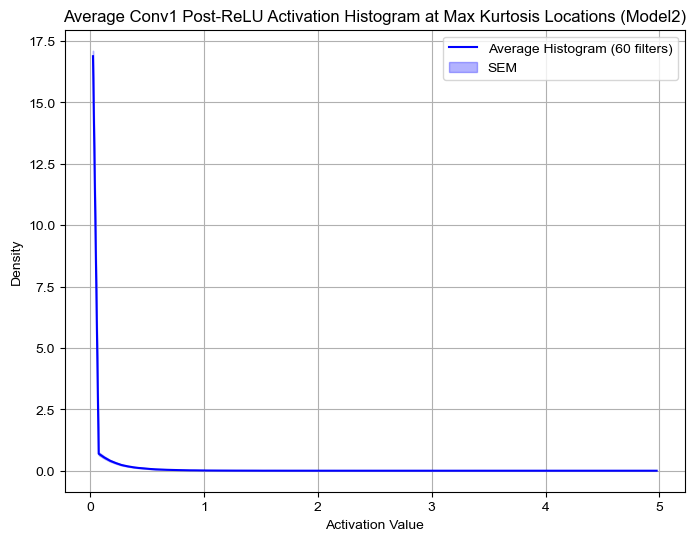

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis  # For computing kurtosis
from matplotlib import rcParams

# Set font to Arial
rcParams['font.family'] = 'Arial'

# Define LeNet-5 model without dropout for color images
class SimpleLeNet5Color(nn.Module):
    def __init__(self):
        super(SimpleLeNet5Color, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6 * 14 * 14, 10)  # Based on CIFAR10 size after conv1 and pooling

    def forward(self, x):
        x = self.conv1(x)
        relu_output = torch.relu(x)  # Post-ReLU activations (before pooling)
        pooled = self.pool(relu_output)
        x = pooled.view(-1, 6 * 14 * 14)
        x = self.fc1(x)
        return x, relu_output

# List to store activations for each model
all_conv1_activations = []

# Process each model and collect conv1 activations (post-ReLU, before pooling)
for n in range(10):
    model = SimpleLeNet5Color()
    model.load_state_dict(torch.load(f'model2_{n}_9.pth'))
    model.eval()

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
    dataloader = DataLoader(cifar_test, batch_size=1000, shuffle=False)

    conv1_activations = None
    with torch.no_grad():
        for inputs, _ in dataloader:
            _, relu_output = model(inputs)
            conv1_activations = relu_output if conv1_activations is None else torch.cat((conv1_activations, relu_output), 0)
    all_conv1_activations.append(conv1_activations.numpy())

# Use fixed bins from 0 to 5 (100 bins)
fixed_bins = np.linspace(0, 5, 101)
histogram_results2 = []  # List of (bin_centers, counts)
kurtosis_results2 = []   # List of max kurtosis values

# Analyze each model's conv1 activations
for activations in all_conv1_activations:
    # activations shape: (num_images, 6, height, width)
    for filter_idx in range(activations.shape[1]):
        filter_activations = activations[:, filter_idx, :, :]  # Shape: (num_images, H, W)

        # Compute kurtosis at each spatial location across the batch
        kurtosis_map = kurtosis(filter_activations, axis=0, fisher=True, nan_policy='omit')
        max_kurtosis = np.nanmax(kurtosis_map)

        # Find the (H, W) location of maximum kurtosis
        max_loc = np.unravel_index(np.nanargmax(kurtosis_map), kurtosis_map.shape)

        # Extract activations at the max-kurtosis location across the batch
        location_activations = filter_activations[:, max_loc[0], max_loc[1]]  # Shape: (N,)

        # Compute histogram at that location
        counts, bin_edges = np.histogram(location_activations, bins=fixed_bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        histogram_results2.append((bin_centers, counts))
        kurtosis_results2.append(max_kurtosis)

# Summary
print("Total histograms computed:", len(histogram_results2))  # Expected: 60
print("Total kurtosis values computed:", len(kurtosis_results2))

# Average the histograms across all filters
all_counts = np.array([entry[1] for entry in histogram_results2])  # shape: (60, 100)
mean_hist = np.mean(all_counts, axis=0)
sem_hist = np.std(all_counts, axis=0) / np.sqrt(all_counts.shape[0])
bin_centers_avg = histogram_results2[0][0]

# Plot the average histogram with SEM shading
plt.figure(figsize=(8, 6))
plt.plot(bin_centers_avg, mean_hist, label='Average Histogram (60 filters)', color='blue')
plt.fill_between(bin_centers_avg, mean_hist - sem_hist, mean_hist + sem_hist,
                 color='blue', alpha=0.3, label='SEM')
plt.xlabel('Activation Value')
plt.ylabel('Density')
plt.title('Average Conv1 Post-ReLU Activation Histogram at Max Kurtosis Locations (Model2)')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Save mean histogram and SEM for later use
mean_hist2 = mean_hist
sem_hist2 = sem_hist

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Total histograms computed: 60
Total kurtosis values computed: 60


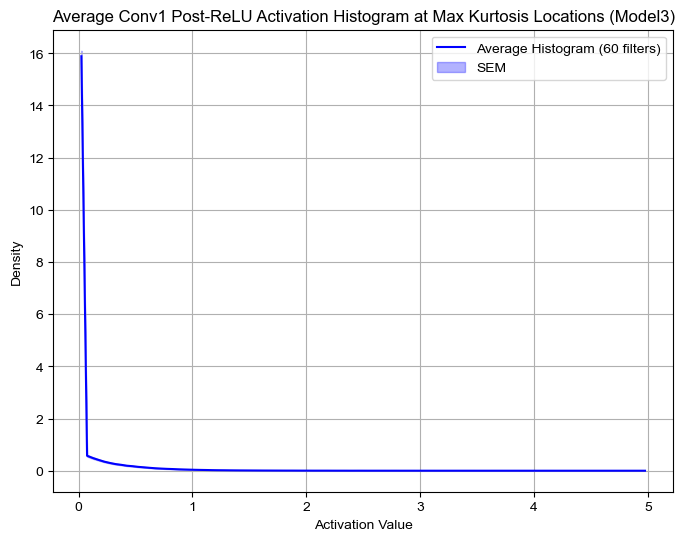

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis
from matplotlib import rcParams

# Set font to Arial
rcParams['font.family'] = 'Arial'

# Define LeNet-5 model for color images (Model 3)
class LeNet5Color(nn.Module):
    def __init__(self):
        super(LeNet5Color, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 10)

    def forward(self, x):
        conv1_pre_relu = self.conv1(x)
        relu_conv1 = torch.relu(conv1_pre_relu)  # Post-ReLU activations (before pooling)
        x = self.pool(relu_conv1)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        return x, relu_conv1

# Collect conv1 activations for each model
all_conv1_activations = []
for n in range(10):
    model = LeNet5Color()
    model.load_state_dict(torch.load(f'model3_{n}_9.pth'))
    model.eval()

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
    dataloader = DataLoader(cifar_test, batch_size=1000, shuffle=False)

    conv1_activations = None
    with torch.no_grad():
        for inputs, _ in dataloader:
            _, relu_conv1_output = model(inputs)
            conv1_activations = relu_conv1_output if conv1_activations is None else torch.cat((conv1_activations, relu_conv1_output), 0)
    all_conv1_activations.append(conv1_activations.numpy())

# Use fixed bins from 0 to 5 (100 bins) for every filter
fixed_bins = np.linspace(0, 5, 101)
histogram_results3 = []
kurtosis_results3 = []

# Process each model's activations
for activations in all_conv1_activations:
    # activations shape: (num_samples, 6, height, width)
    for filter_idx in range(activations.shape[1]):
        filter_activations = activations[:, filter_idx, :, :]  # shape: (num_samples, H, W)

        # Compute kurtosis across the batch for each spatial location
        kurtosis_map = kurtosis(filter_activations, axis=0, fisher=True, nan_policy='omit')

        # Find location of maximum kurtosis
        max_loc = np.unravel_index(np.nanargmax(kurtosis_map), kurtosis_map.shape)
        max_kurtosis = np.nanmax(kurtosis_map)

        # Extract activations at the location with max kurtosis
        location_activations = filter_activations[:, max_loc[0], max_loc[1]]  # shape: (N,)

        # Compute histogram for that location
        counts, bin_edges = np.histogram(location_activations, bins=fixed_bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        histogram_results3.append((bin_centers, counts))
        kurtosis_results3.append(max_kurtosis)

print("Total histograms computed:", len(histogram_results3))  # Expected: 60
print("Total kurtosis values computed:", len(kurtosis_results3))

# Average histograms across all filters
all_counts = np.array([entry[1] for entry in histogram_results3])  # shape: (60, 100)
mean_hist = np.mean(all_counts, axis=0)
sem_hist = np.std(all_counts, axis=0) / np.sqrt(all_counts.shape[0])
bin_centers_avg = histogram_results3[0][0]

# Plot average histogram with SEM shading
plt.figure(figsize=(8, 6))
plt.plot(bin_centers_avg, mean_hist, label='Average Histogram (60 filters)', color='blue')
plt.fill_between(bin_centers_avg, mean_hist - sem_hist, mean_hist + sem_hist,
                 color='blue', alpha=0.3, label='SEM')
plt.xlabel('Activation Value')
plt.ylabel('Density')
plt.title('Average Conv1 Post-ReLU Activation Histogram at Max Kurtosis Locations (Model3)')
plt.legend()
plt.grid(True)
plt.show()

# Save for later use if needed
mean_hist3 = mean_hist
sem_hist3 = sem_hist

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Total histograms computed: 60
Total kurtosis values computed: 60


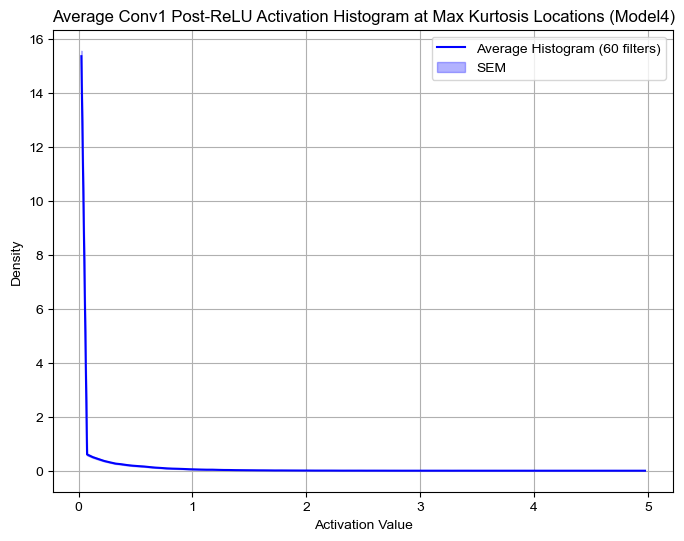

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis  # For computing kurtosis
from matplotlib import rcParams

# Set font to Arial
rcParams['font.family'] = 'Arial'

# Define the 4-layer LeNet-5 model without dropout for color images (Model 4)
class LeNet5Color(nn.Module):
    def __init__(self):
        super(LeNet5Color, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        conv1_pre_relu = self.conv1(x)
        relu_conv1 = torch.relu(conv1_pre_relu)  # Post-ReLU activations (before pooling)
        x = self.pool(relu_conv1)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x, relu_conv1  # Return post-ReLU activations from conv1

# Collect conv1 activations for each of the 10 models
all_conv1_activations = []
for n in range(10):
    model = LeNet5Color()
    model.load_state_dict(torch.load(f'model4_{n}_9.pth'))
    model.eval()

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
    dataloader = DataLoader(cifar_test, batch_size=1000, shuffle=False)

    conv1_activations = None
    with torch.no_grad():
        for inputs, _ in dataloader:
            _, relu_conv1_output = model(inputs)
            conv1_activations = relu_conv1_output if conv1_activations is None else torch.cat((conv1_activations, relu_conv1_output), 0)
    all_conv1_activations.append(conv1_activations.numpy())

# Use fixed bins from 0 to 5 (100 bins) for every filter
fixed_bins = np.linspace(0, 5, 101)
histogram_results4 = []
kurtosis_results4 = []

# Analyze activations from each model
for activations in all_conv1_activations:
    # activations shape: (num_samples, 6, height, width)
    for filter_idx in range(activations.shape[1]):
        filter_activations = activations[:, filter_idx, :, :]  # shape: (N, H, W)

        # Compute kurtosis across the batch at each spatial location
        kurtosis_map = kurtosis(filter_activations, axis=0, fisher=True, nan_policy='omit')

        # Get max kurtosis and location
        max_kurtosis = np.nanmax(kurtosis_map)
        max_loc = np.unravel_index(np.nanargmax(kurtosis_map), kurtosis_map.shape)

        # Extract activations at that max-kurtosis spatial location
        location_activations = filter_activations[:, max_loc[0], max_loc[1]]  # shape: (N,)

        # Compute histogram for that location
        counts, bin_edges = np.histogram(location_activations, bins=fixed_bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        histogram_results4.append((bin_centers, counts))
        kurtosis_results4.append(max_kurtosis)

print("Total histograms computed:", len(histogram_results4))  # Expected: 60
print("Total kurtosis values computed:", len(kurtosis_results4))

# Average the histograms across all filters
all_counts = np.array([entry[1] for entry in histogram_results4])  # shape: (60, 100)
mean_hist = np.mean(all_counts, axis=0)
sem_hist = np.std(all_counts, axis=0) / np.sqrt(all_counts.shape[0])
bin_centers_avg = histogram_results4[0][0]

# Plot average histogram with SEM shading
plt.figure(figsize=(8, 6))
plt.plot(bin_centers_avg, mean_hist, label='Average Histogram (60 filters)', color='blue')
plt.fill_between(bin_centers_avg, mean_hist - sem_hist, mean_hist + sem_hist,
                 color='blue', alpha=0.3, label='SEM')
plt.xlabel('Activation Value')
plt.ylabel('Density')
plt.title('Average Conv1 Post-ReLU Activation Histogram at Max Kurtosis Locations (Model4)')
plt.legend()
plt.grid(True)
plt.show()

# Save if needed
mean_hist4 = mean_hist
sem_hist4 = sem_hist

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Total histograms computed: 60
Total kurtosis values computed: 60


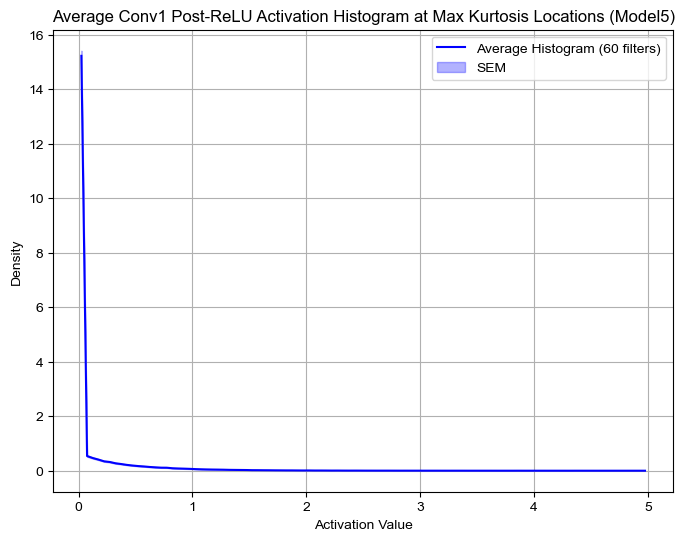

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis  # For computing kurtosis
from matplotlib import rcParams

# Set font to Arial
rcParams['font.family'] = 'Arial'

# Define the 4-layer LeNet-5 model without dropout for color images (Model 5)
class LeNet5Color(nn.Module):
    def __init__(self):
        super(LeNet5Color, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        conv1_pre_relu = self.conv1(x)
        relu_conv1 = torch.relu(conv1_pre_relu)  # Post-ReLU activations (before pooling)
        x = self.pool(relu_conv1)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x, relu_conv1

# List to store conv1 activations for each model
all_conv1_activations = []

# Process each model and extract conv1 activations
for n in range(10):
    model = LeNet5Color()
    model.load_state_dict(torch.load(f'model5_{n}_9.pth'))
    model.eval()

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
    dataloader = DataLoader(cifar_test, batch_size=1000, shuffle=False)

    conv1_activations = None
    with torch.no_grad():
        for inputs, _ in dataloader:
            _, relu_conv1_output = model(inputs)
            conv1_activations = relu_conv1_output if conv1_activations is None else torch.cat((conv1_activations, relu_conv1_output), 0)
    all_conv1_activations.append(conv1_activations.numpy())

# Use fixed bins from 0 to 5 (100 bins)
fixed_bins = np.linspace(0, 5, 101)
histogram_results5 = []
kurtosis_results5 = []

# Analyze activations
for activations in all_conv1_activations:
    # activations shape: (num_samples, 6, H, W)
    for filter_idx in range(activations.shape[1]):
        filter_activations = activations[:, filter_idx, :, :]  # shape: (N, H, W)

        # Compute kurtosis map: (H, W)
        kurtosis_map = kurtosis(filter_activations, axis=0, fisher=True, nan_policy='omit')
        max_kurtosis = np.nanmax(kurtosis_map)
        max_loc = np.unravel_index(np.nanargmax(kurtosis_map), kurtosis_map.shape)

        # Extract activations at max-kurtosis location across batch
        location_activations = filter_activations[:, max_loc[0], max_loc[1]]  # shape: (N,)

        # Compute histogram
        counts, bin_edges = np.histogram(location_activations, bins=fixed_bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        histogram_results5.append((bin_centers, counts))
        kurtosis_results5.append(max_kurtosis)

print("Total histograms computed:", len(histogram_results5))  # Expected: 60
print("Total kurtosis values computed:", len(kurtosis_results5))

# Aggregate and plot results
all_counts = np.array([entry[1] for entry in histogram_results5])  # shape: (60, 100)
mean_hist = np.mean(all_counts, axis=0)
sem_hist = np.std(all_counts, axis=0) / np.sqrt(all_counts.shape[0])
bin_centers_avg = histogram_results5[0][0]

# Plot average histogram
plt.figure(figsize=(8, 6))
plt.plot(bin_centers_avg, mean_hist, label='Average Histogram (60 filters)', color='blue')
plt.fill_between(bin_centers_avg, mean_hist - sem_hist, mean_hist + sem_hist,
                 color='blue', alpha=0.3, label='SEM')
plt.xlabel('Activation Value')
plt.ylabel('Density')
plt.title('Average Conv1 Post-ReLU Activation Histogram at Max Kurtosis Locations (Model5)')
plt.legend()
plt.grid(True)
plt.show()

# Save for reuse
mean_hist5 = mean_hist
sem_hist5 = sem_hist

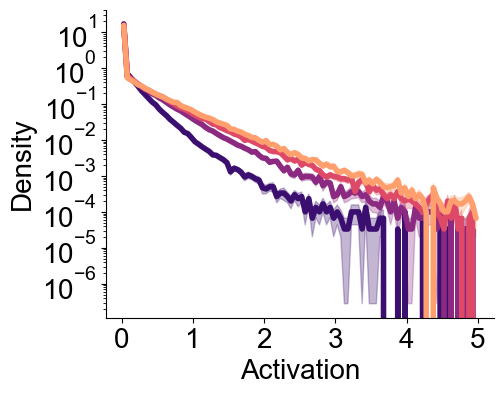

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

rainbow = sns.color_palette("magma", 4)

fig, ax = plt.subplots(figsize=(5, 4))


# Fixed bins from -1 to 1
fixed_bins = np.linspace(0, 5, 101)  # 101 edges yield 100 bins
bin_centers_fixed = (fixed_bins[:-1] + fixed_bins[1:]) / 2

# Set Seaborn style and get a magma palette with 4 colors
sns.set(style="whitegrid")
palette = sns.color_palette("magma", 4)


# Plot for group/model 2 using fixed bins
plt.plot(bin_centers_fixed, mean_hist2, label='Model2', color=palette[0], linewidth=4)
plt.fill_between(bin_centers_fixed, mean_hist2 - sem_hist2, mean_hist2 + sem_hist2,
                 color=palette[0], alpha=0.3)

# Plot for group/model 3 using fixed bins
plt.plot(bin_centers_fixed, mean_hist3, label='Model3', color=palette[1], linewidth=4)
plt.fill_between(bin_centers_fixed, mean_hist3 - sem_hist3, mean_hist3 + sem_hist3,
                 color=palette[1], alpha=0.3)

# Plot for group/model 4 using fixed bins
plt.plot(bin_centers_fixed, mean_hist4, label='Model4', color=palette[2], linewidth=4)
plt.fill_between(bin_centers_fixed, mean_hist4 - sem_hist4, mean_hist4 + sem_hist4,
                 color=palette[2], alpha=0.3)

# Plot for group/model 5 using fixed bins
plt.plot(bin_centers_fixed, mean_hist5, label='Model5', color=palette[3], linewidth=4)
plt.fill_between(bin_centers_fixed, mean_hist5 - sem_hist5, mean_hist5 + sem_hist5,
                 color=palette[3], alpha=0.3)


ax.set_xlabel('Activation', fontname="Arial", fontsize=20)
ax.set_ylabel('Density', fontname="Arial", fontsize=20)
#ax.set_title('Global selectivity', fontname="Arial", fontsize=25, fontweight="bold")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.grid(False)

# Set the font name for axis tick labels to be Arial
for tick in ax.get_xticklabels():
    tick.set_fontname("arial")
    tick.set_fontsize(20)
for tick in ax.get_yticklabels():
    tick.set_fontname("arial")
    tick.set_fontsize(20)

#plt.ylim(.4, .7)
plt.show()


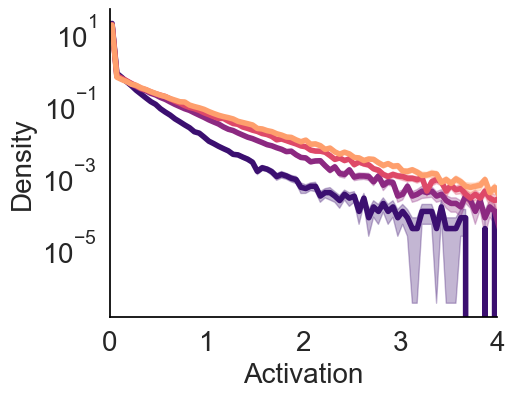

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

rainbow = sns.color_palette("magma", 4)

fig, ax = plt.subplots(figsize=(5, 4))


# Fixed bins from -1 to 1
fixed_bins = np.linspace(0, 5, 101)  # 101 edges yield 100 bins
bin_centers_fixed = (fixed_bins[:-1] + fixed_bins[1:]) / 2

# Set Seaborn style and get a magma palette with 4 colors
sns.set(style="whitegrid")
palette = sns.color_palette("magma", 4)


# Plot for group/model 2 using fixed bins
plt.plot(bin_centers_fixed, mean_hist2, label='Model2', color=palette[0], linewidth=4)
plt.fill_between(bin_centers_fixed, mean_hist2 - sem_hist2, mean_hist2 + sem_hist2,
                 color=palette[0], alpha=0.3)

# Plot for group/model 3 using fixed bins
plt.plot(bin_centers_fixed, mean_hist3, label='Model3', color=palette[1], linewidth=4)
plt.fill_between(bin_centers_fixed, mean_hist3 - sem_hist3, mean_hist3 + sem_hist3,
                 color=palette[1], alpha=0.3)

# Plot for group/model 4 using fixed bins
plt.plot(bin_centers_fixed, mean_hist4, label='Model4', color=palette[2], linewidth=4)
plt.fill_between(bin_centers_fixed, mean_hist4 - sem_hist4, mean_hist4 + sem_hist4,
                 color=palette[2], alpha=0.3)

# Plot for group/model 5 using fixed bins
plt.plot(bin_centers_fixed, mean_hist5, label='Model5', color=palette[3], linewidth=4)
plt.fill_between(bin_centers_fixed, mean_hist5 - sem_hist5, mean_hist5 + sem_hist5,
                 color=palette[3], alpha=0.3)


ax.set_xlabel('Activation', fontname="Arial", fontsize=20)
ax.set_ylabel('Density', fontname="Arial", fontsize=20)
#ax.set_title('Global selectivity', fontname="Arial", fontsize=25, fontweight="bold")

# Hide top/right spines and set left/bottom to black
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.grid(False)


# Set the font name for axis tick labels to be Arial
for tick in ax.get_xticklabels():
    tick.set_fontname("arial")
    tick.set_fontsize(20)
for tick in ax.get_yticklabels():
    tick.set_fontname("arial")
    tick.set_fontsize(20)
    
from matplotlib.ticker import LogLocator

# Set fewer y-ticks for log scale (e.g., 10^-4 to 10^0)
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=5))

plt.xlim([0, 4])
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['0', '1', '2', '3', '4'])
plt.show()


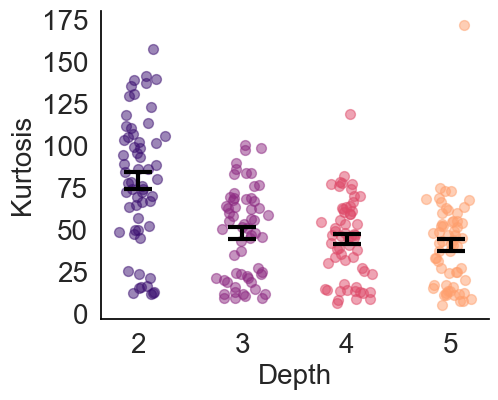

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn's magma palette with 4 colors
rainbow = sns.color_palette("magma", 4)

fig, ax = plt.subplots(figsize=(5, 4))

# Plot for Model2: kurtosis_results2
jitter2 =  np.random.randn(len(kurtosis_results2))*.1 + 2
ax.scatter(jitter2, kurtosis_results2, alpha=0.5, color=rainbow[0], s=50, label='Model2')

# Plot for Model3: kurtosis_results3
jitter3 = np.random.randn(len(kurtosis_results3))*.1 + 3
ax.scatter(jitter3, kurtosis_results3, alpha=0.5, color=rainbow[1], s=50, label='Model3')

# Plot for Model4: kurtosis_results4
jitter4 =  np.random.randn(len(kurtosis_results4))*.1 + 4
ax.scatter(jitter4, kurtosis_results4, alpha=0.5, color=rainbow[2], s=50, label='Model4')

# Plot for Model5: kurtosis_results5
jitter5 = np.random.randn(len(kurtosis_results5))*.1 + 5
ax.scatter(jitter5, kurtosis_results5, alpha=0.5, color=rainbow[3], s=50, label='Model5')


# Compute mean and SEM for each group
mean2 = np.mean(kurtosis_results2)
sem2 = np.std(kurtosis_results2) / np.sqrt(len(kurtosis_results2))

mean3 = np.mean(kurtosis_results3)
sem3 = np.std(kurtosis_results3) / np.sqrt(len(kurtosis_results3))

mean4 = np.mean(kurtosis_results4)
sem4 = np.std(kurtosis_results4) / np.sqrt(len(kurtosis_results4))

mean5 = np.mean(kurtosis_results5)
sem5 = np.std(kurtosis_results5) / np.sqrt(len(kurtosis_results5))

# Define x positions for each group (for example, depth positions: 2, 3, 4, 5)
x = [2, 3, 4, 5]
y = [mean2, mean3, mean4, mean5]
yerr = [sem2, sem3, sem4, sem5]

# Plot big fat black dot with error bars (vertical only, no horizontal caps)
plt.errorbar(x, y, yerr=yerr, fmt='|', markersize=6, color='black',
             ecolor='black', elinewidth=3, capsize=10, capthick=3)

ax.set_xlabel('Depth', fontname="Arial", fontsize=20)
ax.set_ylabel('Kurtosis', fontname="Arial", fontsize=20)
ax.set_xticks(range(2, 6))
# Ensure ticks are visible and black

# Hide top/right spines and set left/bottom to black
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
# Set font for tick labels
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
    tick.set_fontsize(20)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
    tick.set_fontsize(20)

plt.grid(False)
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind
import pandas as pd

# Input data
kurtosis_2_layers = kurtosis_results2
kurtosis_3_layers = kurtosis_results3
kurtosis_4_layers = kurtosis_results4
kurtosis_5_layers = kurtosis_results5

# ANOVA test
anova_result = f_oneway(kurtosis_2_layers, kurtosis_3_layers, kurtosis_4_layers, kurtosis_5_layers)

# Degrees of freedom for ANOVA
k = 4  # number of groups
n_total = (
    len(kurtosis_2_layers) +
    len(kurtosis_3_layers) +
    len(kurtosis_4_layers) +
    len(kurtosis_5_layers)
)
df_between = k - 1
df_within = n_total - k

# Print ANOVA result
print(f'ANOVA result: F({df_between}, {df_within}) = {anova_result.statistic:.4f}, p = {anova_result.pvalue:.4e}')

# Pairwise t-tests with Bonferroni correction
comparisons = [
    ("2 vs 3", kurtosis_2_layers, kurtosis_3_layers),
    ("2 vs 4", kurtosis_2_layers, kurtosis_4_layers),
    ("2 vs 5", kurtosis_2_layers, kurtosis_5_layers),
]

for label, group1, group2 in comparisons:
    t_stat, p_val = ttest_ind(group1, group2)
    p_val_corrected = p_val * len(comparisons)
    df_t = len(group1) + len(group2) - 2
    print(f'T-test {label}: t({df_t}) = {t_stat:.4f}, p (Bonferroni corrected) = {p_val_corrected:.4e}')

ANOVA result: F(3, 236) = 21.3439, p = 2.8766e-12
T-test 2 vs 3: t(118) = 5.1314, p (Bonferroni corrected) = 3.4311e-06
T-test 2 vs 4: t(118) = 5.9291, p (Bonferroni corrected) = 9.3047e-08
T-test 2 vs 5: t(118) = 6.3361, p (Bonferroni corrected) = 1.3377e-08


In [ ]:
smoothed_histograms_5_layers.shape

In [ ]:
import numpy as np

smoothed_histograms_5_layers_array = np.array(smoothed_histograms_5_layers)
print(smoothed_histograms_5_layers_array.shape)

In [ ]:
matrix.shape[1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Define color palette
rainbow = sns.color_palette("magma", 4)

# Define figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Your provided kurtosis function
def compute_kurtosis(activations):
    return stats.kurtosis(activations, axis=(0, 2, 3), fisher=True)

# Wrapper to compute mean kurtosis per model
def calculate_mean_kurtosis(models):
    # models is a list of 4D arrays (e.g., [10, C, H, W])
    return [np.mean(compute_kurtosis(model)) for model in models]

# Depth 2
kurtosis_2 = calculate_mean_kurtosis(smoothed_histograms_2_layers)
jitter = 0.25 * np.random.rand(len(kurtosis_2)) + 2
plt.scatter(jitter, kurtosis_2, alpha=0.7, color=rainbow[0], s=100)

# Depth 3
kurtosis_3 = calculate_mean_kurtosis(smoothed_histograms_3_layers)
jitter = 0.25 * np.random.rand(len(kurtosis_3)) + 3
plt.scatter(jitter, kurtosis_3, alpha=0.7, color=rainbow[1], s=100)

# Depth 4
kurtosis_4 = calculate_mean_kurtosis(smoothed_histograms_4_layers)
jitter = 0.25 * np.random.rand(len(kurtosis_4)) + 4
plt.scatter(jitter, kurtosis_4, alpha=0.7, color=rainbow[2], s=100)

# Depth 5
kurtosis_5 = calculate_mean_kurtosis(smoothed_histograms_5_layers)
jitter = 0.25 * np.random.rand(len(kurtosis_5)) + 5
plt.scatter(jitter, kurtosis_5, alpha=0.7, color=rainbow[3], s=100)

# Labeling and aesthetics
ax.set_xlabel('Depth', fontname="Arial", fontsize=20)
ax.set_ylabel('Kurtosis', fontname="Arial", fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(range(2, 6))

for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
    tick.set_fontsize(20)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
    tick.set_fontsize(20)

plt.show()

In [ ]:
np.array(all_conv1_activations).shape

In [ ]:
import numpy as np
from scipy.stats import kurtosis

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Assume `data` is your array of shape (10, 10000, 6, 28, 28)
import numpy as np
from scipy.stats import kurtosis

def compute_filterwise_kurtosis(data):
    # data shape: (10, 10000, 6, 28, 28)
    avg_kurtosis = []

    for i in range(data.shape[0]):  # Loop over 10 models
        model_data = data[i]  # shape: (10000, 6, 28, 28)
        model_kurtosis_values = []

        for stim in range(model_data.shape[0]):  # 10000 stimuli
            for filt in range(model_data.shape[1]):  # 6 filters
                activation_slice = model_data[stim, filt, :, :].ravel()  # shape (784,)
                k = kurtosis(activation_slice, fisher=True)
                model_kurtosis_values.append(k)

        # Average over 60,000 values
        avg_kurtosis.append(np.mean(model_kurtosis_values))

    return avg_kurtosis  # List of 10 values (1 per model)

# Define color palette
rainbow = sns.color_palette("magma", 4)

# Define figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

smoothed_histograms_2_layers = np.array(smoothed_histograms_2_layers)
smoothed_histograms_3_layers = np.array(smoothed_histograms_3_layers)
smoothed_histograms_4_layers = np.array(smoothed_histograms_4_layers)
smoothed_histograms_5_layers = np.array(smoothed_histograms_5_layers)


# Depth 2
kurtosis_2 = compute_filterwise_kurtosis(smoothed_histograms_2_layers)
jitter = 0.25 * np.random.rand(len(kurtosis_2)) + 2
plt.scatter(jitter, kurtosis_2, alpha=0.7, color=rainbow[0], s=100)

# Depth 3
kurtosis_3 = compute_filterwise_kurtosis(smoothed_histograms_3_layers)
jitter = 0.25 * np.random.rand(len(kurtosis_3)) + 3
plt.scatter(jitter, kurtosis_3, alpha=0.7, color=rainbow[1], s=100)

# Depth 4
kurtosis_4 = compute_filterwise_kurtosis(smoothed_histograms_4_layers)
jitter = 0.25 * np.random.rand(len(kurtosis_4)) + 4
plt.scatter(jitter, kurtosis_4, alpha=0.7, color=rainbow[2], s=100)

# Depth 5
kurtosis_5 = compute_filterwise_kurtosis(smoothed_histograms_5_layers)
jitter = 0.25 * np.random.rand(len(kurtosis_5)) + 5
plt.scatter(jitter, kurtosis_5, alpha=0.7, color=rainbow[3], s=100)

# Labeling and aesthetics
ax.set_xlabel('Depth', fontname="Arial", fontsize=20)
ax.set_ylabel('Kurtosis', fontname="Arial", fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(range(2, 6))

for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
    tick.set_fontsize(20)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
    tick.set_fontsize(20)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import seaborn as sns

def compute_avg_kurtosis_per_model(data):
    avg_kurtosis = []

    for i in range(data.shape[0]):  # Loop over models
        model_data = data[i]  # shape: (10000, num_filters, 28, 28)
        model_kurtosis_values = []

        for filt in range(model_data.shape[1]):  # num_filters
            # Get all activations for this filter across all stimuli
            filter_acts = model_data[:, filt, :, :]  # shape (10000, 28, 28)
            filter_acts_flat = filter_acts.reshape(filter_acts.shape[0], -1)  # (10000, 784)

            # Normalize each 28x28 slice (per stimulus) using global mean/std for this filter
            mean = filter_acts_flat.mean()
            std = filter_acts_flat.std()
            if std == 0:
                std = 1e-6  # prevent divide-by-zero

            normalized = (filter_acts_flat - mean) / std

            # Compute kurtosis per slice
            for j in range(normalized.shape[0]):
                k = kurtosis(normalized[j], fisher=True)
                model_kurtosis_values.append(k)

        avg_kurtosis.append(np.mean(model_kurtosis_values))

    return avg_kurtosis  # One value per model

# Compute kurtosis per model for each depth
kurtosis_2 = compute_avg_kurtosis_per_model(np.array(smoothed_histograms_2_layers))
kurtosis_3 = compute_avg_kurtosis_per_model(np.array(smoothed_histograms_3_layers))
kurtosis_4 = compute_avg_kurtosis_per_model(np.array(smoothed_histograms_4_layers))
kurtosis_5 = compute_avg_kurtosis_per_model(np.array(smoothed_histograms_5_layers))

# Plotting
fig, ax = plt.subplots(figsize=(6, 5))
rainbow = sns.color_palette("magma", 4)

# Depth 2
jitter = 0.25 * np.random.rand(len(kurtosis_2)) + 2
plt.scatter(jitter, kurtosis_2, alpha=0.7, color=rainbow[0], s=100)

# Depth 3
jitter = 0.25 * np.random.rand(len(kurtosis_3)) + 3
plt.scatter(jitter, kurtosis_3, alpha=0.7, color=rainbow[1], s=100)

# Depth 4
jitter = 0.25 * np.random.rand(len(kurtosis_4)) + 4
plt.scatter(jitter, kurtosis_4, alpha=0.7, color=rainbow[2], s=100)

# Depth 5
jitter = 0.25 * np.random.rand(len(kurtosis_5)) + 5
plt.scatter(jitter, kurtosis_5, alpha=0.7, color=rainbow[3], s=100)

# Styling
ax.set_xlabel('Depth', fontname="Arial", fontsize=20)
ax.set_ylabel('Kurtosis', fontname="Arial", fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(range(2, 6))

for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
    tick.set_fontsize(20)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
    tick.set_fontsize(20)

plt.show()

In [1]:
!python --version
!pip show scikit-learn
!pip show torch

Python 3.9.13
Name: scikit-learn
Version: 1.0.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /Users/mitchellslapik/opt/anaconda3/lib/python3.9/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: librosa, scikit-learn-intelex
Name: torch
Version: 2.2.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /Users/mitchellslapik/opt/anaconda3/lib/python3.9/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchaudio, torchdata, torchtext, torchvision, torchviz
